<a href="https://colab.research.google.com/github/mldessu/projetsimu/blob/main/Chaleur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

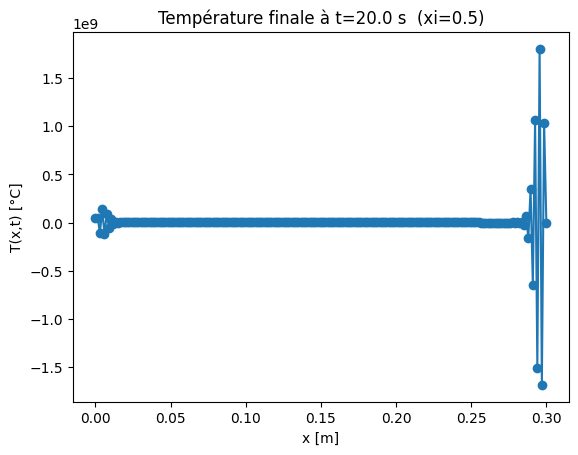

In [25]:
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
# Paramètres physiques
##############################################################################
L   = 0.30      # [m] épaisseur du mur
k   = 1.0       # [W/(m*K)] conductivité
h   = 1.0       # [W/(m^2*K)] convection à x=0
Ta  = -10.0     # [°C] température extérieure
Ti  = 20.0      # [°C] température intérieure voulue
rho = 2000.0    # [kg/m^3] densité
cv  = 1000.0    # [J/(kg*K)] capacité thermique

##############################################################################
# Paramètres pour la source S(x)
##############################################################################
q   = 2000.0
dL  = 0.05
# S(x) = q * [ 1 + ((x-L)/dL)^2 ]
# On construit le vecteur Sdiscr ci-dessous

##############################################################################
# Conditions aux limites dans la forme c1..c3 et d1..d3
#   x=0:  -k dT/dx = h(Ta - T) => c1=-k, c2=h, c3=-h*Ta
#   x=L:  T(L,t)=Ti => d1=0, d2=1, d3=-Ti
##############################################################################
c1, c2, c3 = -k, h, -h*Ta
d1, d2, d3 =  0, 1, -Ti

##############################################################################
# Discrétisation spatiale
##############################################################################
N   = 200           # nombre de segments
dx  = L / N
x   = np.linspace(0, L, N+1)

# Construisons la source discrète:
Sdiscr = q * (1.0 + ((x - L)/dL)**2)

##############################################################################
# Condition initiale: T(x,0) = Tw + (Ti - Tw)* x/L
##############################################################################
Tw = (Ti*k/L + Ta*h)/(k/L + h)   # T(0) "extrapolée"
Tn = Tw + (Ti - Tw)*(x / L)      # tableau (N+1)

##############################################################################
# Paramètres de temps
##############################################################################
dt  = 0.1      # [s] pas de temps
Nt  = 200      # nombre de pas de temps
xi  = 0.5      # xi=1 => Euler implicite; xi=0.5 => Crank-Nicolson

##############################################################################
# 1) Construire la matrice A_sta (Laplacien + CL) : taille (N+1)x(N+1)
##############################################################################
A_sta = np.diag(-2*np.ones(N+1),0) \
      + np.diag(np.ones(N), -1)    \
      + np.diag(np.ones(N),  1)

# Bord x=0: -k dT/dx = h(Ta-T) => c1*dT/dx + c2*T + c3=0 => 3 points
A_sta[0,0] = 2*c2*dx - 3*c1
A_sta[0,1] = 4*c1
A_sta[0,2] = -c1

# Bord x=L: T(L)=Ti => d1*dT/dx + d2*T + d3=0 => d2*T + d3=0 => T=Ti
#   => ligne i=N : A_sta[N,N]=1,  b[N]=Ti  (ou la forme "3 points" du pdf)
#   Dans la version "Méthode de la matrice 1d.pdf", on met:
#     A_sta[N,N] = d2
#     A_sta[N,N-1] = 0
#     A_sta[N,N-2] = 0
#   et ajuster le second membre...
A_sta[N,:] = 0.0
A_sta[N,N] = d2  # =1
# (on n’utilise pas d1 dans ce cas, car d1=0 => flux non imposé)

##############################################################################
# Matrice identité (pour la partie T^n)
##############################################################################
I_sta = np.eye(N+1)

##############################################################################
# Boucle en temps
##############################################################################
solutions = [Tn.copy()]  # pour garder un historique (si besoin)

for it in range(Nt):
    # Facteur alpha = (k * dt)/(rho * cv * dx^2)
    alpha = (k * dt) / (rho * cv * dx**2)

    # --- 2) Construire la matrice A qui multiplie T^{n+1}
    #     A = I + alpha * xi * A_sta
    A = I_sta + alpha * xi * A_sta

    # --- 3) Construire le second membre b
    #     b = [I - alpha*(1 - xi)*A_sta] * T^n + (dt/k)*S(x) + ...
    b = (I_sta - alpha*(1.0 - xi)*A_sta).dot(Tn)
    b += (dt/k) * Sdiscr

    # -- Gérer le bord x=L => T(L)=Ti => On fixe T_{N}^{n+1} = Ti
    #    Cela se fait en imposant A[N,N]=1; b[N] = Ti, et 0 ailleurs
    b[0] += -2.0 * c3 * dx  # condition convective (correction 3 points)

    # Pour la Dirichlet pure: on surimpose la valeur T(L)=Ti
    #   => A[N,:]=0, A[N,N]=1 déjà fait, donc:
    b[N] = Ti

    # -- 4) Résoudre A*T^{n+1} = b
    Tnp1 = np.linalg.solve(A, b)

    # -- 5) Mise à jour
    Tn = Tnp1
    solutions.append(Tn.copy())

##############################################################################
# Tracé de la solution finale
##############################################################################
plt.figure()
plt.plot(x, Tn, '-o')
plt.xlabel("x [m]")
plt.ylabel("T(x,t) [°C]")
plt.title(f"Température finale à t={Nt*dt} s  (xi={xi})")
plt.show()

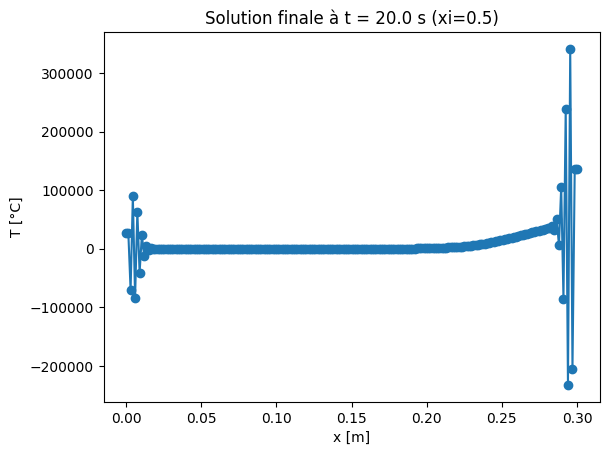

In [20]:
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
# Paramètres physiques
##############################################################################
L  = 0.3           # [m] épaisseur du mur
k  = 1.0           # [W/(m*K)]
h  = 1.0           # [W/(m^2*K)]
Ta = -10.0         # [°C] T° extérieure
Ti = 20.0          # [°C] T° intérieure cible
rho= 2000.0        # [kg/m^3]
cv = 1000.0        # [J/(kg*K)]

# Coeff. de la condition de convection au bord x=0 : -k dT/dx = h(Ta - T)
c1 = -k
c2 =  h
c3 = -h*Ta

# Coeff. de la condition Neumann au bord x=L : dT/dx = 0
d1 =  1
d2 =  0
d3 =  0

##############################################################################
# Paramètres de discrétisation en espace
##############################################################################
N  = 200             # nb de subdivisions
dx = L / N
x  = np.linspace(0, L, N+1)

# Source volumique (comme dans le code initial)
q  = 2000.0
dL = 0.05
S  = q * np.exp( -((x - L)/dL)**2 )   # vecteur (N+1)

##############################################################################
# NOUVEAU / MODIFIÉ: Paramètres de temps et méthode
##############################################################################
dt   = 0.1          # [s] pas de temps
Nt   = 200          # nombre de pas de temps
xi   = 0.5         # xi=1 -> Euler implicite; xi=0.5 -> Crank-Nicolson; etc.

##############################################################################
# Calcul de T(0,x) (condition initiale)
# Ex.: interpolation linéaire entre Tw et Ti
##############################################################################
Tw = (Ti*k/L + Ta*h)/(k/L + h)  # T extrapolée côté x=0
Tn = np.zeros(N+1)
for i in range(N+1):
    Tn[i] = Tw + (Ti - Tw)*(x[i]/L)  # distribution initiale

##############################################################################
# Construction (une seule fois) de la matrice "A_sta" pour le Laplacien + CL
##############################################################################
A_sta = np.diag(-2*np.ones(N+1), 0) \
      + np.diag(np.ones(N), -1)    \
      + np.diag(np.ones(N),  1)

# Conditions de bord "3 points" à x=0
A_sta[0, 0] =  2*c2*dx - 3*c1
A_sta[0, 1] =  4*c1
A_sta[0, 2] = -c1

# Conditions de bord "3 points" à x=L
A_sta[N, N]     = 3*d1 + 2*d2*dx
A_sta[N, N-1]   = -4*d1
A_sta[N, N-2]   = d1

# Matrice identité (utile pour la partie T^p)
B_id = np.eye(N+1)
# (Si besoin, on peut ajuster la 1ère et dernière ligne pour respecter
#  la structure "3 points", comme indiqué dans Méthode_de_la_matrice_1d.pdf.)

##############################################################################
# Boucle en temps : méthode implicite (ou mixte) en fonction de xi
##############################################################################
solutions = []        # si on veut stocker l'évolution
solutions.append(Tn.copy())

for p in range(Nt):

    # Facteur alpha = (k * dt)/(rho * cv * dx^2)
    alpha = (k*dt)/(rho*cv*(dx**2))

    # 1) Construction de la matrice A = (I + alpha*xi*A_sta)
    A = B_id + alpha * xi * A_sta

    # 2) Construction du second membre b :
    #    b = [I - alpha*(1 - xi)*A_sta]*T^p + dt/k * S + ajustements CL
    b = ( B_id - alpha*(1.0 - xi)*A_sta ).dot(Tn)
    b += (dt / k)*S

    # Appliquer les termes de bord (c3, d3) comme dans le stationnaire
    b[0] += -2.0 * c3 * dx
    b[N] += -2.0 * d3 * dx

    # 3) Résolution du système A * T^{p+1} = b
    Tnp1 = np.linalg.solve(A, b)

    # 4) Mise à jour
    Tn = Tnp1
    solutions.append(Tn.copy())

##############################################################################
# Tracé de la solution finale
##############################################################################
plt.figure()
plt.plot(x, Tn, '-o')
plt.xlabel("x [m]")
plt.ylabel("T [°C]")
plt.title(f"Solution finale à t = {Nt*dt:.1f} s (xi={xi})")
plt.show()